In [3]:
import numpy as np
import pandas as pd
import scipy as sci
import math as math
import itertools
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [4]:
df=pd.read_table('~/Data_Mining/dm_hw3_dataset.csv', sep=',')

In [5]:
# this is a less detailed result variable, so it is removed since it gives the same information as our y
del df['healthyInd']

In [66]:
list(df.columns)

['age',
 'gender',
 'chestPainType',
 'tRestBps',
 'cholesteral',
 'fBsLt120',
 'restEcg',
 'maxHr',
 'exerIndAngina',
 'oldPeak',
 'slope',
 'noVessColored',
 'thal',
 'indicator']

In [5]:
df[df['thal']=='?']

,age,gender,chestPainType,tRestBps,cholesteral,fBsLt120,restEcg,maxHr,exerIndAngina,oldPeak,slope,noVessColored,thal,indicator
82,53.0,fem,notang,128.0,216.0,fal,hyp,115.0,fal,0.0,up,0.0,?,H
198,52.0,male,asympt,128.0,204.0,true,norm,156.0,true,1.0,flat,0.0,?,S2


In [6]:
df[df['noVessColored']=='?']

,age,gender,chestPainType,tRestBps,cholesteral,fBsLt120,restEcg,maxHr,exerIndAngina,oldPeak,slope,noVessColored,thal,indicator
143,52.0,male,notang,138.0,223.0,fal,norm,169.0,fal,0.0,up,?,norm,H
157,38.0,male,notang,138.0,175.0,fal,norm,173.0,fal,0.0,up,?,norm,H
165,43.0,male,asympt,132.0,247.0,true,hyp,143.0,true,0.1,flat,?,rev,S1
250,58.0,male,abnang,125.0,220.0,fal,norm,144.0,fal,0.4,flat,?,rev,H
262,38.0,male,notang,138.0,175.0,fal,norm,173.0,fal,0.0,up,?,norm,H


In [6]:
# the unknown values mess with the classifier, since we can not know the actual value they are removed
df=df[(df['noVessColored']!='?') & (df['thal']!='?')]

In [9]:
# the vessels column was originally marked as char since there was a '?' present. it is reassigned as a numerical value. 
#df['noVessColored'] = df['noVessColored'].apply(pd.to_numeric)
#df.dtypes

age              float64
gender            object
chestPainType     object
tRestBps         float64
cholesteral      float64
fBsLt120          object
restEcg           object
maxHr            float64
exerIndAngina     object
oldPeak          float64
slope             object
noVessColored    float64
thal              object
indicator         object
dtype: object

In [7]:
# the features are all marked as numeric or categorical for future manipulation
all_features = set(df.columns)-set(['indicator'])
num_features = set(df.describe().columns)-set(['indicator'])
cat_features = all_features-num_features

print("All features:         ", ", ".join(all_features), "\nNumerical features:   ", ", ".join(num_features), "\nCategorical features: ", ", ".join(cat_features))

All features:          cholesteral, restEcg, noVessColored, chestPainType, slope, gender, exerIndAngina, age, fBsLt120, thal, tRestBps, oldPeak, maxHr 
Numerical features:    cholesteral, age, tRestBps, oldPeak, maxHr 
Categorical features:  restEcg, noVessColored, chestPainType, slope, gender, exerIndAngina, thal, fBsLt120


In [8]:
# the dataset is split into predictors & prediction
X = df[list(cat_features)]
y = df['indicator']

In [9]:
# the categorical variables are transformed to dummy values
df2 = pd.get_dummies(X,columns = cat_features)
df2.head()

,restEcg_abn,restEcg_hyp,restEcg_norm,noVessColored_0.0,noVessColored_1.0,noVessColored_2.0,noVessColored_3.0,chestPainType_abnang,chestPainType_angina,chestPainType_asympt,...,slope_up,gender_fem,gender_male,exerIndAngina_fal,exerIndAngina_true,thal_fix,thal_norm,thal_rev,fBsLt120_fal,fBsLt120_true
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


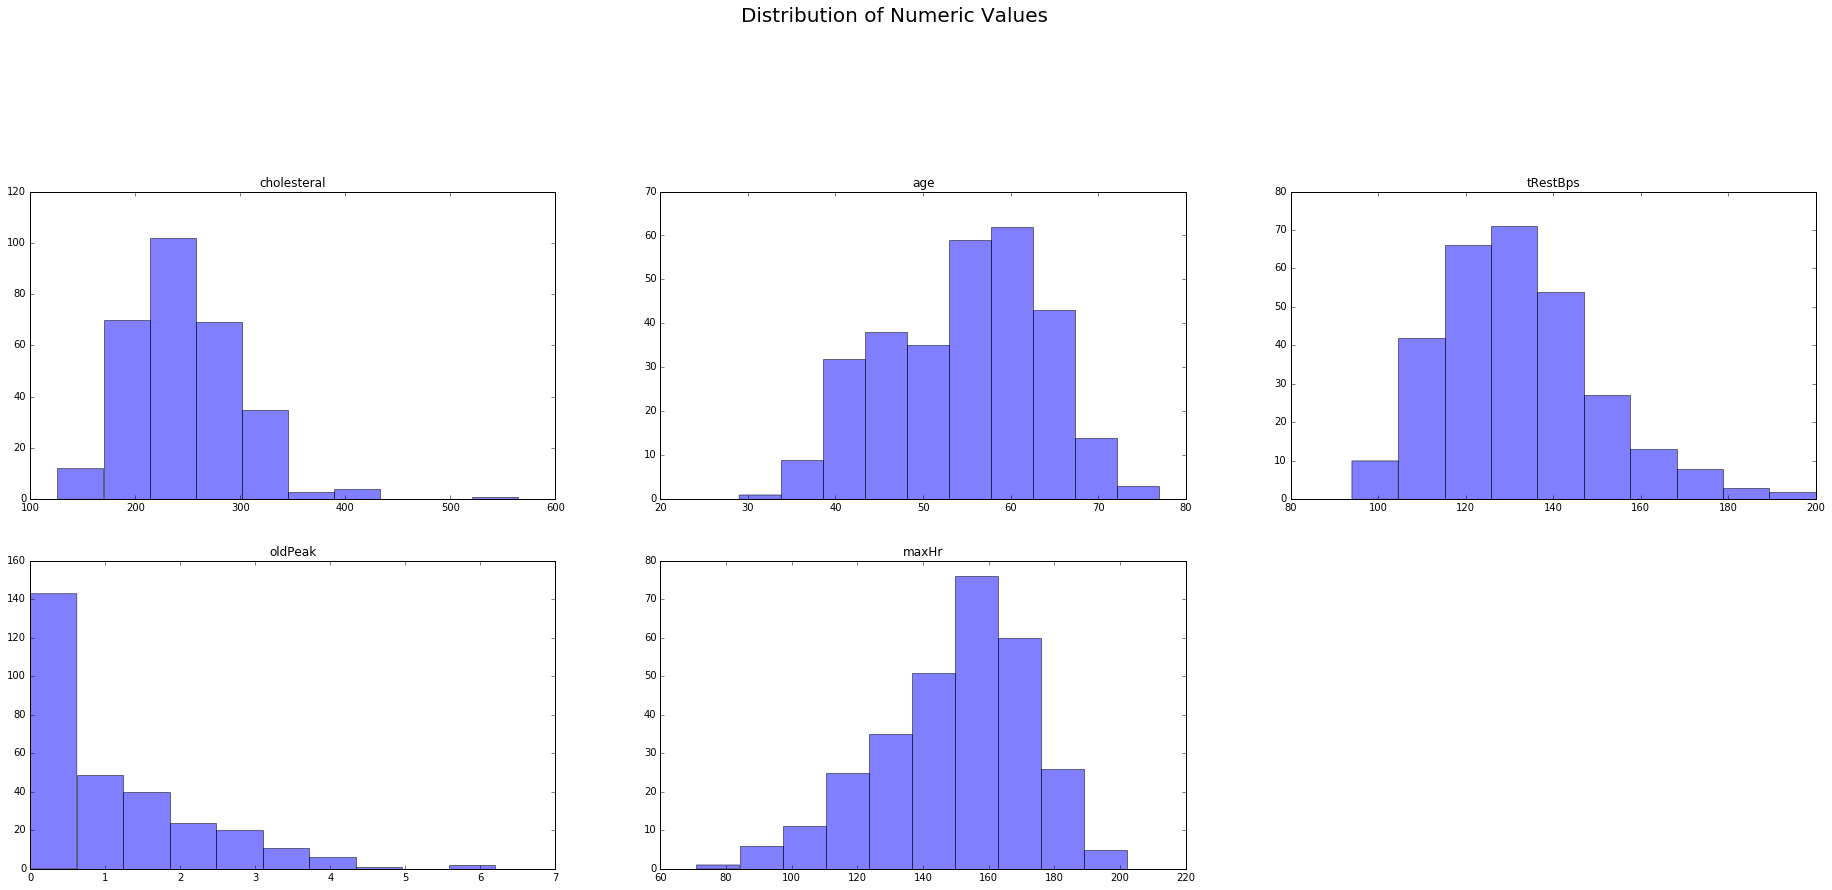

In [10]:
# plot the numerical values to get a sense of the data
%matplotlib inline
fig = plt.figure(figsize=(32, 32))
for i in range(len(num_features)):
    f = list(num_features)[i]
    plt.subplot(5, 3, i+1)
    hst = plt.hist(df[f].dropna(axis=0), alpha=0.5)
    plt.title(f)
plt.suptitle('Distribution of Numeric Values', fontsize=20)
fig.savefig('num_features.png')
None

In [11]:
df.describe()

,age,tRestBps,cholesteral,maxHr,oldPeak
count,296.000000,296.00000,296.000000,296.000000,296.000000
mean,54.523649,131.60473,247.155405,149.560811,1.059122
std,9.059471,17.72662,51.977011,22.970792,1.166474
min,29.000000,94.00000,126.000000,71.000000,0.000000
25%,48.000000,120.00000,211.000000,133.000000,0.000000
50%,56.000000,130.00000,242.500000,152.500000,0.800000
75%,61.000000,140.00000,275.250000,166.000000,1.650000
max,77.000000,200.00000,564.000000,202.000000,6.200000


#rescale the x numeric values to reduce bias, except the oldPeak since this does not follow a normal distribution & is already close to 0. 

In [12]:
df2['oldPeak']=df['oldPeak']

In [13]:
values = df[['age', 'tRestBps', 'maxHr', 'cholesteral']]

In [14]:
for i in values.columns:
    scaler = StandardScaler()
    scaler = scaler.fit(values[i])
    normalized = scaler.transform(values[i])
    df2[i]=normalized

df2.head()    

/usr/lib64/python3.4/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib64/python3.4/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib64/python3.4/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1)

,restEcg_abn,restEcg_hyp,restEcg_norm,noVessColored_0.0,noVessColored_1.0,noVessColored_2.0,noVessColored_3.0,chestPainType_abnang,chestPainType_angina,chestPainType_asympt,...,thal_fix,thal_norm,thal_rev,fBsLt120_fal,fBsLt120_true,oldPeak,age,tRestBps,maxHr,cholesteral
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.3,0.937219,0.756938,0.019152,-0.272801
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.5,1.379493,1.604556,-1.812353,0.748607
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,2.6,1.379493,-0.655759,-0.896601,-0.349888
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,3.5,-1.937566,-0.090680,1.632621,0.054821
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.4,-1.495292,-0.090680,0.978512,-0.831685


In [15]:
# summarize the predictions
y.value_counts()

H     160
S1     53
S2     35
S3     35
S4     13
Name: indicator, dtype: int64

In [16]:
# encode prediction values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

In [17]:
# convert X to a matrix
X = df2.values
X, y

(array([[ 0.        ,  1.        ,  0.        , ...,  0.75693814,
          0.01915184, -0.27280094],
        [ 0.        ,  1.        ,  0.        , ...,  1.60455613,
         -1.81235338,  0.74860744],
        [ 0.        ,  1.        ,  0.        , ..., -0.65575852,
         -0.89660077, -0.34988836],
        ..., 
        [ 0.        ,  1.        ,  0.        , ..., -0.76877425,
         -1.02742257, -1.89163686],
        [ 0.        ,  1.        ,  0.        , ..., -0.65575852,
         -1.2454589 ,  0.42098589],
        [ 0.        ,  0.        ,  1.        , ...,  1.60455613,
          0.58604631, -0.88950034]]), array([[ 1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.]]))

In [32]:
# define base model for 5 output
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(28, input_dim=28, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation='relu'))  
    model.add(Dense(5, init='normal',activation='sigmoid')) 
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [37]:
# fix random seed for reproducibility
seed = 9
np.random.seed(seed)
# create model
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100,shuffle=True, batch_size=32, verbose=0)

In [38]:
# evaluate model with 9-fold cross validation
np.random.seed(seed)
kfold = KFold(n_splits=9, random_state=seed, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 60.10% (8.81%)


25-25-9-9-5 Accuracy: 59.46% (5.88%) (relu)    -- less variance
25-25-11-11-5 Accuracy: 58.08% (8.57%) (relu)
25-25-7-7-5 Accuracy: 59.10% (7.68%) (relu)
25-25-9-9-9-5 Accuracy: 59.44% (6.53%) (relu)

In [ ]:
# run the prediction on our data
model = estimator.fit(X,y)
ŷ = model.predict(X)

In [ ]:
results = model.score(X, y)
print("Standardized: %.2f" % results)
print("Standardized: %.2f (%.2f)" % (results.mean(), results.std()))

In [ ]:
#attach our prediction to the original dataset and view the output
df['ŷ']=encoder.inverse_transform(ŷ)
df['ŷ'].value_counts()

In [ ]:
# compare the prediction to the actual 
%matplotlib inline
fig = plt.figure(figsize=(7,5))
import collections
a = collections.Counter(df['indicator'])
b = collections.Counter(df['ŷ'])
l1 = np.arange(5)
plt.bar(l1, a.values(), .5, color='blue', label='Indicator')
plt.xticks(l1, a.keys())
plt.bar(l1+.5, b.values(), .5, color ='red', label='ŷ')
plt.xticks(l1, b.keys())
plt.legend(loc='upper left')
fig.savefig('neural_net.png')

In [ ]:
pred_list=df['ŷ'].unique()

In [ ]:
# View the confusion matrix
confusion_matrix(df['indicator'], df['ŷ'], labels=pred_list)

In [ ]:
# plot the confusion matrix in a better format, viewing both the normalized & unnormalized output
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(df['indicator'], df['ŷ'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=pred_list,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=pred_list, normalize=True,
                      title='Normalized confusion matrix')

plt.show()